In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
from torch.utils.data import TensorDataset,DataLoader
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
from torchvision import models

from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler,normalize
import sklearn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import numpy as np
import pickle
from tqdm import tqdm

In [2]:
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()   


[nltk_data] Downloading package wordnet to /home/yl535/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
Visual_genome_path = '/local/scratch/yl535/visualgeno/'
work_path = '/local/scratch/yl535/'

cuda:0


In [3]:

relations = pd.read_json(Visual_genome_path+'relationships.json')

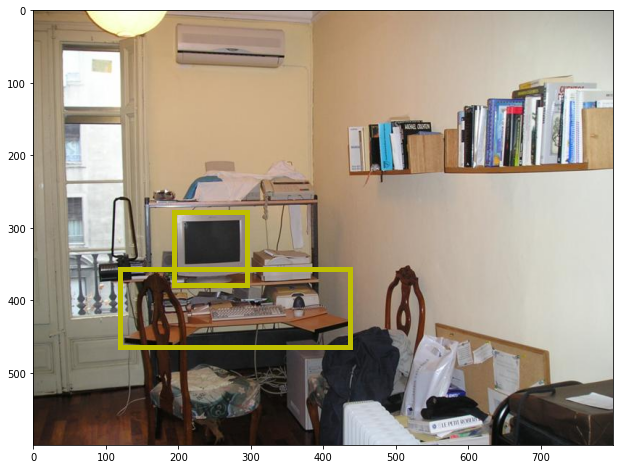

subject:  computer monitor
object:  desk
relation:  ON


In [42]:

def plot_example(idx, re_idx, relations):
    img_id = relations.iloc[idx]['image_id']
    re = relations.iloc[idx]['relationships'][re_idx]
    path = work_path+'/visualgeno/VG_100K/{}.jpg'.format(img_id)
    path = path if os.path.isfile(path) else '../visualgeno/VG_100K_2/{}.jpg'.format(img_id)
    img = mpimg.imread(path)
#     fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [16, 8]
    fig, ax = plt.subplots()
    ax.imshow(img)
    pat_subject = patches.Rectangle((re['subject']['x'],re['subject']['y']),re['subject']['w'],re['subject']['h'],
                            lw=5, color='y',
                            fill=False)
    pat_object = patches.Rectangle((re['object']['x'],re['object']['y']),re['object']['w'],re['object']['h'],
                            lw=5, color='y',
                            fill=False)
    ax.add_patch(pat_subject)
    ax.add_patch(pat_object)
    plt.show()
    
    name_pred = re['predicate']
    name_subj = re['subject']['name'] if 'name' in re['subject'] else re['subject']['names']
    name_obj = re['object']['name'] if 'name' in re['object'] else re['object']['names']
    print('subject: ',name_subj)
    print('object: ',name_obj)
    print('relation: ',name_pred)

plot_example(4,8, relations)
#4,8

In [25]:
data_size = 0
for i in range(len(relations)):
    data_size += len(relations.iloc[i].relationships)

data_size

2316104

## Preparing data

In [5]:
def crop_image(img,obj):
    
    return img[obj['y']:obj['y']+obj['h'],
               obj['x']:obj['x']+obj['w'],:]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [8]:

resnet = models.resnet101(pretrained=True)
resnet.to(device)
resnet.eval()

data_cut = 3000
Image_batch_size = 20000
data_sect_cnt = 0
tokenizer = get_tokenizer("basic_english")


for section in range(27,36):
    data_startpoint = section*data_cut
    
    X,Y = [],[]
    print('data loading')
    for i in tqdm(range(data_startpoint, data_startpoint+data_cut)):
        img_id = relations.iloc[i]['image_id']
        path_folder1 = Visual_genome_path+'VG_100K/{}.jpg'.format(img_id)
        path_folder2 = Visual_genome_path+'VG_100K_2/{}.jpg'.format(img_id)
        path = path_folder1 if os.path.isfile(path_folder1) else path_folder2

        img_pred = mpimg.imread(path)
        if len(img_pred.shape)<3:
            continue

        for n, relation in enumerate(relations.iloc[i]['relationships']):
#             if (relation['synsets']==[]) or (relation['subject']['synsets']==[]) or (relation['object']['synsets']==[]):
#                 print(relation['subject']['synsets'],
#                       relation['synsets'],
#                       relation['object']['synsets'],
#                       relation['predicate'])
#                 continue
                
            ####
            if relation['synsets']==[]:
                if relation['predicate']=='':
#                     print('skip predicate')
                    continue
                else:
                    name_pred = [relation['predicate']]
            else:
                name_pred = [term.split('.')[0] for term in relation['synsets']]
                
            #### subj
            if relation['subject']['synsets']==[]:
                subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
                if subj=='':
#                     print('skip subject')
                    continue
                else:
                    subjs = subj.split(' ')
                    name_subj = []
                    for term in subjs:
                        if wordnet.synsets(term)!=[]:
                            name_subj.append(wordnet.synsets(term)[0].name().split('.')[0])
                        else:
                            continue
                    if len(name_subj)==0:
#                         print('skip subject')
#                         print(subj)
                        continue
            else:
                name_subj = [term.split('.')[0] for term in relation['subject']['synsets']]
                
            #### obj
            if relation['object']['synsets']==[]:
                obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
                if obj=='':
#                     print('skip object')
                    continue
                else:
                    objs = obj.split(' ')
                    name_obj = []
                    for term in objs:
                        if wordnet.synsets(term)!=[]:
                            name_obj.append(wordnet.synsets(term)[0].name().split('.')[0])
                        else:
                            continue
                    if len(name_obj)==0:
#                         print('skip object')
#                         print(obj)
                        continue
            else:
                name_obj = [term.split('.')[0] for term in relation['object']['synsets']]
                
                
            img_subj = crop_image(img_pred,relation['subject'])
            img_obj = crop_image(img_pred,relation['object'])

#             name_pred = [term.split('.')[0] for term in relation['synsets']]
#             name_subj = [term.split('.')[0] for term in relation['subject']['synsets']]
#             name_obj = [term.split('.')[0] for term in relation['object']['synsets']]
            
#             name_pred = relation['predicate']
#             name_subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
#             name_obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
            
            if (0 in img_subj.shape) or (0 in img_obj.shape):
#                 print('skip one broken image')
                continue
            
#             if name_pred=='' or name_subj=='' or name_obj=='':
#                 print('skip one empty pred')
#                 continue
            for s in name_subj:
                for p in name_pred:
                    for o in name_obj:
                        if s=='arch':
                            print(relation)
                        X.append([img_pred, img_subj, img_obj])
                        Y.append([p, s, o])
    assert False
    #looping
    print('X length:', len(X))
    Image_batch_number = np.floor(len(X)/Image_batch_size)
    x_hidden = []
#     Y_flat = []
    for start_point in range(0,len(X),Image_batch_size):
        end_point = start_point+Image_batch_size if start_point+Image_batch_size<len(X) else len(X) 

        X_transformed = []
        print('image transforming')
        for row in tqdm(X[start_point:end_point]):
            X_transformed += [transform(img) for img in row]
        X_transformed = torch.cat(X_transformed).reshape((-1,3,224,224)) # the X_transformed is 10000*3*224*224

        x_loader = DataLoader(X_transformed,batch_size=500)
        del X_transformed
        with torch.no_grad():     # have to use no_grad() otherwise there will be memory leck
            output = []
            print('passing CNN')
            for x_batch in tqdm(x_loader):
                output_batch = resnet(x_batch.to(device))
                output.append(output_batch)
                
        del x_loader
        x_hidden.append(torch.cat(output).cpu().reshape((-1,3,1000)))
        del output
        
#         for row in Y[start_point:end_point]:
#             Y_flat.append([lemmatizer.lemmatize(tokenizer(word)[0]) for word in row])
    print('saving data')
    pickle.dump(torch.Tensor(np.concatenate(x_hidden)), open(work_path+"data_v2/x_preprocessed_{}.p".format(section), "wb"))
    pickle.dump(np.array(Y), open(work_path+"data_v2/y_preprocessed_{}.p".format(section), "wb"))
    del x_hidden
    del Y_flat
    data_sect_cnt += 1
    
    


  1%|          | 16/3000 [00:00<00:19, 155.31it/s]

data loading


  4%|▍         | 130/3000 [00:00<00:15, 182.30it/s]

{'predicate': 'IN', 'object': {'name': 'fence', 'h': 100, 'synsets': ['fence.n.01'], 'object_id': 3469795, 'w': 100, 'y': 175, 'x': 398}, 'relationship_id': 4068899, 'synsets': ['be.v.01'], 'subject': {'name': 'archway', 'h': 146, 'synsets': ['arch.n.03'], 'object_id': 3469796, 'w': 27, 'y': 62, 'x': 369}}
{'predicate': 'above', 'object': {'name': 'clock', 'h': 22, 'synsets': ['clock.n.01'], 'object_id': 2158794, 'w': 30, 'y': 109, 'x': 146}, 'relationship_id': 4069648, 'synsets': ['above.r.01'], 'subject': {'name': 'archway', 'h': 21, 'synsets': ['arch.n.03'], 'object_id': 3704189, 'w': 139, 'y': 261, 'x': 88}}


  8%|▊         | 250/3000 [00:01<00:14, 190.04it/s]

{'predicate': 'ON THE', 'object': {'name': 'wall', 'h': 274, 'synsets': ['wall.n.01'], 'object_id': 2076216, 'w': 107, 'y': 11, 'x': 162}, 'relationship_id': 4071040, 'synsets': ['along.r.01'], 'subject': {'name': 'arch', 'h': 50, 'synsets': ['arch.n.01'], 'object_id': 2076215, 'w': 62, 'y': 151, 'x': 181}}
{'predicate': 'ON', 'object': {'h': 445, 'object_id': 2987969, 'merged_object_ids': [2261120, 3500037, 2827983, 3409081, 2603522, 2992385, 3930924], 'synsets': ['church.n.01'], 'w': 241, 'y': 52, 'x': 0, 'names': ['big church']}, 'relationship_id': 4071877, 'synsets': ['along.r.01'], 'subject': {'name': 'archways', 'h': 54, 'synsets': ['arch.n.03'], 'object_id': 2990343, 'w': 47, 'y': 444, 'x': 98}}
{'predicate': 'ON', 'object': {'h': 445, 'object_id': 2987969, 'merged_object_ids': [2261120, 3500037, 2827983, 3409081, 2603522, 2992385, 3930924], 'synsets': ['church.n.01'], 'w': 241, 'y': 52, 'x': 0, 'names': ['big church']}, 'relationship_id': 4071878, 'synsets': ['along.r.01'], 'su

 33%|███▎      | 977/3000 [00:05<00:10, 198.61it/s]

{'predicate': 'in front of', 'object': {'name': 'tower', 'h': 464, 'synsets': ['tower.n.01'], 'object_id': 2260932, 'w': 332, 'y': 33, 'x': 0}, 'relationship_id': 4083010, 'synsets': ['in.r.01'], 'subject': {'name': 'arch', 'h': 141, 'synsets': ['arch.n.01'], 'object_id': 3709649, 'w': 329, 'y': 356, 'x': 3}}
{'predicate': 'IN', 'object': {'name': 'tower', 'h': 278, 'synsets': ['tower.n.01'], 'object_id': 1044760, 'w': 123, 'y': 0, 'x': 163}, 'relationship_id': 3131844, 'synsets': ['in.r.01'], 'subject': {'name': 'archway', 'h': 83, 'synsets': ['arch.n.03'], 'object_id': 1044784, 'w': 45, 'y': 194, 'x': 202}}


 40%|███▉      | 1191/3000 [00:06<00:09, 185.94it/s]

{'predicate': 'behind', 'object': {'name': 'fence', 'h': 116, 'synsets': [], 'object_id': 4579076, 'w': 267, 'y': 147, 'x': 4}, 'relationship_id': 4792188, 'synsets': [], 'subject': {'name': 'archway', 'h': 118, 'synsets': [], 'object_id': 4579075, 'w': 59, 'y': 133, 'x': 144}}


 43%|████▎     | 1293/3000 [00:06<00:08, 191.84it/s]

{'predicate': 'OF', 'object': {'name': 'building', 'h': 58, 'synsets': ['building.n.01'], 'object_id': 959496, 'w': 28, 'y': 77, 'x': 60}, 'relationship_id': 2854669, 'synsets': [], 'subject': {'name': 'arches', 'h': 80, 'synsets': ['arch.n.01'], 'object_id': 959500, 'w': 44, 'y': 286, 'x': 195}}


 55%|█████▍    | 1639/3000 [00:08<00:07, 193.20it/s]

{'predicate': 'made on', 'object': {'h': 499, 'object_id': 2878624, 'merged_object_ids': [3663764, 2611764], 'synsets': ['tower.n.01'], 'w': 287, 'y': 0, 'x': 66, 'names': ['tower']}, 'relationship_id': 3967823, 'synsets': ['make.v.01'], 'subject': {'name': 'arch', 'h': 91, 'synsets': ['arch.n.01'], 'object_id': 3421274, 'w': 33, 'y': 297, 'x': 124}}


 68%|██████▊   | 2044/3000 [00:10<00:05, 189.51it/s]

{'predicate': 'ON', 'object': {'name': 'roof', 'h': 93, 'synsets': ['roof.n.01'], 'object_id': 961260, 'w': 190, 'y': 2, 'x': 6}, 'relationship_id': 2860614, 'synsets': ['along.r.01'], 'subject': {'name': 'arch', 'h': 77, 'synsets': ['arch.n.01'], 'object_id': 961259, 'w': 152, 'y': 3, 'x': 123}}


 79%|███████▊  | 2356/3000 [00:12<00:03, 179.02it/s]

{'predicate': 'under', 'object': {'name': 'bridge', 'h': 147, 'synsets': [], 'object_id': 4618352, 'w': 365, 'y': 65, 'x': 132}, 'relationship_id': 4808434, 'synsets': [], 'subject': {'name': 'archway', 'h': 88, 'synsets': [], 'object_id': 4618353, 'w': 192, 'y': 112, 'x': 225}}


 80%|████████  | 2411/3000 [00:12<00:03, 174.34it/s]

{'predicate': 'under', 'object': {'name': 'bridge', 'h': 227, 'synsets': ['bridge.n.01'], 'object_id': 2109808, 'w': 282, 'y': 49, 'x': 1}, 'relationship_id': 3978732, 'synsets': ['under.r.01'], 'subject': {'name': 'archway', 'h': 150, 'synsets': ['arch.n.03'], 'object_id': 3667804, 'w': 115, 'y': 124, 'x': 39}}
{'predicate': 'over', 'object': {'name': 'window', 'h': 33, 'synsets': ['window.n.01'], 'object_id': 2691154, 'w': 22, 'y': 298, 'x': 122}, 'relationship_id': 4450854, 'synsets': [], 'subject': {'name': 'arch', 'h': 42, 'synsets': [], 'object_id': 3925035, 'w': 56, 'y': 262, 'x': 95}}
{'predicate': 'over', 'object': {'name': 'window', 'h': 44, 'synsets': ['window.n.01'], 'object_id': 2691153, 'w': 24, 'y': 287, 'x': 162}, 'relationship_id': 4450853, 'synsets': [], 'subject': {'name': 'arch', 'h': 75, 'synsets': ['arch.n.01'], 'object_id': 2691155, 'w': 117, 'y': 237, 'x': 89}}


 85%|████████▌ | 2563/3000 [00:13<00:02, 184.24it/s]

{'predicate': 'over', 'object': {'name': 'windows', 'h': 20, 'synsets': [], 'object_id': 4627134, 'w': 157, 'y': 141, 'x': 125}, 'relationship_id': 4812072, 'synsets': [], 'subject': {'name': 'arches', 'h': 39, 'synsets': [], 'object_id': 4627133, 'w': 164, 'y': 92, 'x': 114}}


100%|██████████| 3000/3000 [00:15<00:00, 188.51it/s]

{'predicate': 'behind', 'object': {'name': 'screen', 'h': 225, 'synsets': ['screen.n.01'], 'object_id': 3202872, 'w': 258, 'y': 0, 'x': 8}, 'relationship_id': 3990015, 'synsets': ['behind.r.01'], 'subject': {'name': 'arch', 'h': 225, 'synsets': ['arch.n.01'], 'object_id': 3202871, 'w': 248, 'y': 2, 'x': 16}}


AssertionError: 

## cleaning data

In [6]:
# predicate_list = np.array([])
predicate_list = []
pixie_dim=1000
tokenizer = get_tokenizer("basic_english")
batch_number = 36

for itr in range(batch_number):
    Y_flat = pickle.load(open(work_path+"data_v2/y_preprocessed_{}.p".format(itr), "rb")).reshape(-1)
#     Y_flat = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat])
    predicate_list.append(Y_flat)
    
predicate_list, predicate_count = np.unique(np.concatenate(predicate_list),return_counts=True)
predicates_table = {w:i for i,w in enumerate(predicate_list)}
predicate_size = len(predicates_table)

rare_pred = predicate_list[predicate_count<3]
predicate_size, len(rare_pred)

(24394, 14168)

In [5]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gloveModel = loadGloveModel("/local/scratch/yl535/glove.42B.300d.txt")
glove_vocab = gloveModel.keys()
del gloveModel

Loading Glove Model
1917494  words loaded!


In [7]:
# filter by glove vocab and rare words
clean_pred_list = []
for pred in predicate_list:
    if (pred not in rare_pred):
        clean_pred_list.append(pred)
        
predicate_list.shape, len(clean_pred_list)

((24394,), 10226)

In [ ]:

for itr in tqdm(range(batch_number)):
    x_hidden = pickle.load(open(work_path+"data_v2/x_preprocessed_{}.p".format(itr), "rb"))
    Y_flat = pickle.load(open(work_path+"data_v2/y_preprocessed_{}.p".format(itr), "rb"))
    
    x_processed = torch.Tensor([])
    y_processed = []
    flag = []
    for x, y in zip(x_hidden,Y_flat.reshape(-1,3)):
#         if np.sum([y_pred=='' for y_pred in y])>0:
#             flag.append(False)
        if np.sum([y_pred not in clean_pred_list for y_pred in y]) != 0:
            flag.append(False)
        else:
            flag.append(True)
#         x_processed = torch.cat((x_processed, torch.Tensor(x)))
#         y_processed.append([tokenizer(y_pred)[0] for y_pred in y])

    y_filtered = Y_flat.reshape(-1,3)[flag]
    y_preds = np.array([pred.lower() for pred in y_filtered.reshape(-1)]).reshape(-1,3)
    
    pickle.dump(x_hidden[flag], open(work_path+"data_v2_preprocessed/x_preprocessed_{}.p".format(itr), "wb"))
    pickle.dump(y_preds, open(work_path+"data_v2_preprocessed/y_preprocessed_{}.p".format(itr), "wb"))
    
    

 17%|█▋        | 6/36 [01:58<10:25, 20.84s/it]

In [14]:
'ON TOP'.lower()

'on top'

(<matplotlib.image.AxesImage at 0x7f4ebcdc83d0>, 'soil')

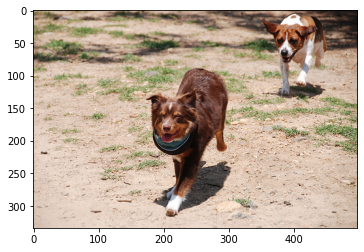

In [15]:
i=0
j=1
plt.imshow(X[i][j]),Y[i][j]

In [16]:
# pickle.dump(X, open("X.p", "wb"))
# pickle.dump(Y, open('Y.p', 'wb'))

## Load processed data

In [22]:

pixie_dim = 1000

cov_global = torch.zeros(pixie_dim,pixie_dim)
data_size = 0
batch_number = 36

for itr in tqdm(range(batch_number)):
    x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/x_preprocessed_{}.p".format(itr), "rb")).reshape(-1, pixie_dim)
    
    diff = x_hidden - torch.mean(x_hidden,0)

    cov_batch = torch.matmul(diff.T,diff)/x_hidden.shape[0]
    cov_global = cov_global*(data_size/(data_size+x_hidden.shape[0])) \
                + cov_batch*(x_hidden.shape[0]/(data_size+x_hidden.shape[0]))
    
    data_size += x_hidden.shape[0]
    
# PCA transform matrix
pixie_dim_new = 20
eigen_vals, eigen_vecs = np.linalg.eig(cov_global)
eigen_vecs_sorted = np.array([x for _, x in sorted(zip(eigen_vals, eigen_vecs), key=lambda pair: pair[0], reverse=True)])
eigen_vals_sorted = sorted(eigen_vals, reverse=True)
x_eigenval = eigen_vals_sorted[:pixie_dim_new]
W = eigen_vecs_sorted[:,:pixie_dim_new]


100%|██████████| 36/36 [01:11<00:00,  1.99s/it]


In [23]:
# PCA transforming 

x_batch = []
y_batch = []
batch_cnt = 0
batch_number = 36
for itr in tqdm(range(batch_number)):
    x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/x_preprocessed_{}.p".format(itr), "rb")).reshape(-1, pixie_dim)
    Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/y_preprocessed_{}.p".format(itr), "rb"))

    x_pca = x_hidden.reshape(-1,pixie_dim).numpy().dot(W)
    x = x_pca/(0.4*np.sqrt(x_eigenval[:pixie_dim_new]))
    x_batch.append(torch.Tensor(x))
    y_batch.append(Y_flat)

    if (np.mod(itr,20)==0 and itr!=0) or itr == batch_number-1:
        x_batch = torch.cat(x_batch)
        y_batch = np.concatenate(y_batch)
        
        pickle.dump(x_batch.reshape(-1,3,pixie_dim_new), open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(batch_cnt), "wb"))
        pickle.dump(y_batch, open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(batch_cnt), "wb"))
        
        x_batch = []
        y_batch = []
        batch_cnt += 1


    

100%|██████████| 36/36 [01:10<00:00,  1.96s/it]


In [4]:
x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_0.p", "rb"))


In [1]:
import pickle 
work_path = '/local/scratch/yl535/'

x = pickle.load(open(work_path+"pixie_data/data_pca/x_preprocessed.p", "rb"))
y = pickle.load(open(work_path+"pixie_data/data_pca/y_preprocessed.p", "rb"))



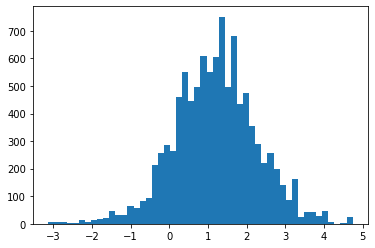

In [22]:
import matplotlib.pyplot as plt
x_cut = x.reshape(-1,20)[:,9]
plt.hist(x_cut[:10000].numpy(),bins=50)
plt.show()

In [6]:
y[0]

array(['along', 'shade', 'sidewalk'], dtype='<U61')